In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
#############################################
#############################################

df = pd.read_csv("../../data/diabetes.csv")

#############################################
#############################################

df.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')

In [29]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [30]:
#######################################################
#######################################################
y = df['target']
X = df.drop(columns=['target'])
#######################################################
#######################################################

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, shuffle=True
)

print("Shapes -> X_train:", X_train.shape, " | X_test:", X_test.shape)

Shapes -> X_train: (327, 10)  | X_test: (110, 10)


In [31]:
#################################################################
cols_num = ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
cols_cat = ['sex']
#################################################################
X_train_num = X_train[cols_num]
X_train_cat = X_train[cols_cat]
X_test_num = X_test[cols_num]
X_test_cat = X_test[cols_cat]

In [32]:
X_train_cat

,sex
14,1
298,2
354,2
199,1
219,1
...,...
323,2
192,2
117,1
47,1


In [33]:
########## codificado de columnas categoricas
# Nota este paso depende de EXPERIENCIA
####################################################################
cols_onehot  = ['sex']      #NOMINALES -> One Hot
cols_ordinal = [] #ORDINALES -> Ordinal

# Categorías ordenadas para las ordinales (mismo orden que en cols_ordinal)
categorias_ordinales = [['1','2']]# lista de listas
####################################################################
preprocessor_cat = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(sparse_output=False, drop=None, handle_unknown="ignore"), cols_onehot),
        ("ordinal", OrdinalEncoder(categories=categorias_ordinales, handle_unknown="use_encoded_value", unknown_value=-1), cols_ordinal),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

preprocessor_cat.fit(X_train_cat)

X_train_cat_proc = preprocessor_cat.transform(X_train_cat)
X_test_cat_proc = preprocessor_cat.transform(X_test_cat)

# -----------------------------------------
# Renombrar One-Hot a formato col___categoria
# -----------------------------------------
onehot = preprocessor_cat.named_transformers_.get("onehot")

rename_map = {}
if onehot is not None and len(cols_onehot) > 0:
    for col, cats in zip(cols_onehot, onehot.categories_):
        for cat in cats:
            old = f"{col}_{cat}"      # nombre que entrega sklearn con verbose_feature_names_out=False
            new = f"{col}___{cat}"    # triple guion bajo deseado
            rename_map[old] = new

# Obtener nombres del ColumnTransformer y aplicar renombres solo a OHE
cols_out_cat = preprocessor_cat.get_feature_names_out()
cols_out_cat = [rename_map.get(c, c) for c in cols_out_cat]

# Reconstruir DataFrames con índices originales
df_train_cat_encode = pd.DataFrame(X_train_cat_proc, columns=cols_out_cat, index=X_train_cat.index)
df_test_cat_encode  = pd.DataFrame(X_test_cat_proc,  columns=cols_out_cat, index=X_test_cat.index)

In [34]:
df_test_cat_encode

,sex___1,sex___2
259,1.0,0.0
278,0.0,1.0
317,1.0,0.0
208,1.0,0.0
54,1.0,0.0
...,...,...
68,0.0,1.0
320,1.0,0.0
20,1.0,0.0
141,1.0,0.0


In [35]:
###########################
########################### DIAGNÓSTICO DE COLUMNAS
###########################


# 1) Detecta numéricas
print("Columnas numéricas:", cols_num)

# 2) Funciones auxiliares
def iqr_outlier_stats(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0, 0.0, np.nan, np.nan, np.nan, np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lim_inf, lim_sup = q1 - 1.5*iqr, q3 + 1.5*iqr
    n_out = int(((s < lim_inf) | (s > lim_sup)).sum())
    prop_out = n_out / len(s)
    return n_out, prop_out, q1, q3, lim_inf, lim_sup

def bounded_guess(s: pd.Series):
    """Detecta si parece estar acotada en [0,1] o [0,100]."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return None
    mn, mx = float(s.min()), float(s.max())
    if 0.0 <= mn and mx <= 1.0:
        return "[0,1]"
    if 0.0 <= mn and mx <= 100.0:
        return "[0,100]"
    return None

if len(cols_num) == 0:
    print("No hay columnas numéricas en X_train. No se generan imágenes.")
else:
    # --------- Figura 1: HISTOGRAMAS (todos en subplots) ----------
    n = len(cols_num)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols_num):
        s = pd.to_numeric(X_train[col], errors="coerce").dropna()
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.hist(s, bins=30)
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")

    # Oculta subplots sobrantes
    for j in range(len(cols_num), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas de columnas numéricas", y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig("histogramas_numericas.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

    # --------- Figura 2: BOXPLOTS (todas en un eje) ----------
    series_pairs = []
    for c in cols_num:
        v = pd.to_numeric(X_train[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos numéricos válidos para boxplots. No se genera boxplot.")
        box_path = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6*len(labels)+4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots de columnas numéricas")
        plt.tight_layout()
        fig2.savefig("boxplots_numericas.png", dpi=150, bbox_inches="tight")
        plt.close(fig2)


# ================================
# Diagnóstico numérico + heurística
# ================================
diagnostico = []
for c in cols_num:
    s = pd.to_numeric(X_train[c], errors="coerce")
    miss_pct = s.isna().mean() * 100
    s_no_na = s.dropna()
    skew = s_no_na.skew() if s_no_na.size > 1 else np.nan
    kurt = s_no_na.kurt() if s_no_na.size > 1 else np.nan
    n_out, prop_out, q1, q3, li, ls = iqr_outlier_stats(s)
    bounds = bounded_guess(s)

    # Heurística de imputación
    if (prop_out >= 0.05) or (pd.notna(skew) and abs(skew) >= 1.0):
        imputador = "median"
    else:
        imputador = "mean"

    # Heurística de escalado
    if prop_out >= 0.05:
        escalador = "RobustScaler"
    elif pd.notna(skew) and abs(skew) <= 0.5:
        escalador = "StandardScaler"
    else:
        escalador = "MinMaxScaler"  # por defecto en casos no normales o acotados

    diagnostico.append({
        "columna": c,
        "missing_%": round(miss_pct, 2),
        "skew": round(skew, 3) if pd.notna(skew) else np.nan,
        "kurtosis": round(kurt, 3) if pd.notna(kurt) else np.nan,
        "outliers_n": n_out,
        "outliers_%": round(prop_out*100, 2),
        "q1": q1, "q3": q3, "IQR": (q3 - q1),
        "lim_inf": li, "lim_sup": ls,
        "bounded": bounds,
        "recom_imputer": imputador,
        "recom_scaler": escalador,
    })

diag_df = pd.DataFrame(diagnostico).sort_values(["outliers_%","missing_%"], ascending=False)
print("\n=== Diagnóstico numérico (heurística) ===\n")

##########################################################
##########################################################

# print(diag_df)

##########################################################
##########################################################

# Sugerencias de bloques numéricos (incluye median+Robust)
suggest_mean_rob = diag_df.query("recom_imputer=='mean' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_rob  = diag_df.query("recom_imputer=='median' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_min  = diag_df.query("recom_imputer=='median' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_med_std  = diag_df.query("recom_imputer=='median' and recom_scaler=='StandardScaler'")["columna"].tolist()
suggest_mean_min = diag_df.query("recom_imputer=='mean' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_mean_std = diag_df.query("recom_imputer=='mean' and recom_scaler=='StandardScaler'")["columna"].tolist()

print("\nSugerencias de bloques numéricos (auto):")
print("median+Robust   :", suggest_med_rob)
print("median+MinMax   :", suggest_med_min)
print("median+Standard :", suggest_med_std)
print("mean+Robust     :", suggest_mean_rob)
print("mean+MinMax     :", suggest_mean_min)
print("mean+Standard   :", suggest_mean_std)

Columnas numéricas: ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

=== Diagnóstico numérico (heurística) ===


Sugerencias de bloques numéricos (auto):
median+Robust   : []
median+MinMax   : []
median+Standard : []
mean+Robust     : []
mean+MinMax     : ['s2', 's3', 'bmi', 's4']
mean+Standard   : ['s1', 's6', 's5', 'age', 'bp']


In [36]:
# --- Listas de columnas ---
# Nota este paso depende de EXPERIENCIA
# Numéricas
# num_med_rob_cols: inputacion mediana con escalado robusto
# num_med_min_cols: inputación mediana con escalado min_max
# num_med_std_cols: inputacion mediana con escalado Estandar
# num_mean_rob_cols: inputación media con escalado robusto
# num_mean_min_cols: inputacion media con escalado min_max
# num_mean_std_cols: inputacion media con escalado Estandar

#########################################################
#########################################################

#num_med_rob_cols = []   # mediana + Robust
#num_med_min_cols = []   # mediana + MinMax
#num_med_std_cols = []   # mediana + Estandar
#num_mean_rob_cols = []   # media + Robust
num_mean_min_cols  = ['s2', 's3', 'bmi', 's4']    # media + MinMax
num_mean_std_cols  = ['s1', 's6', 's5', 'age', 'bp']

#########################################################
#########################################################

#passthrough_cols = []                      # pasar sin procesar
#drop_cols        = []                      # eliminar

#########################################################
#########################################################

In [37]:
# --- Pipelines NUMÉRICOS ---
'''pipe_med_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  RobustScaler())
])'''



'''pipe_med_min = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  MinMaxScaler())
])'''



'''pipe_med_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])'''





'''pipe_mean_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  RobustScaler())
])'''



pipe_mean_min = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  MinMaxScaler())
])



pipe_mean_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])



In [38]:
# --- Listas de columnas ---
# Nota este paso depende de EXPERIENCIA
# Numéricas
# num_med_rob_cols: inputacion mediana con escalado robusto
# num_med_min_cols: inputación mediana con escalado min_max
# num_med_std_cols: inputacion mediana con escalado Estandar
# num_mean_rob_cols: inputación media con escalado robusto
# num_mean_min_cols: inputacion media con escalado min_max
# num_mean_std_cols: inputacion media con escalado Estandar


#########################################################
#########################################################


#num_med_rob_cols = []   # mediana + Robust
#num_med_min_cols = []   # mediana + MinMax
#num_med_std_cols = []   # mediana + Estandar
#num_mean_rob_cols = []   # media + Robust
num_mean_min_cols = ['s2', 's3', 'bmi', 's4']  # media + MinMax
num_mean_std_cols = ['s1', 's6', 's5', 'age', 'bp']

#########################################################
#########################################################


#passthrough_cols = []                      # pasar sin procesar
#drop_cols        = []                      # eliminar


#########################################################
#########################################################

# --- Pipelines NUMÉRICOS ---
'''pipe_med_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  RobustScaler())
])'''

'''pipe_med_min = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  MinMaxScaler())
])'''

'''pipe_med_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])'''

'''pipe_mean_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  RobustScaler())
])'''

pipe_mean_min = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

pipe_mean_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# --- ColumnTransformer unificado ---
preprocessor_num = ColumnTransformer(
    transformers=[
        #("num_med_rob", pipe_med_rob, num_med_rob_cols),
        #("num_med_min", pipe_med_min, num_med_min_cols),
        #("num_med_std", pipe_med_std, num_med_std_cols),
        #("num_mean_rob",  pipe_mean_rob,  num_mean_rob_cols),
        ("num_mean_min", pipe_mean_min, num_mean_min_cols),
        ("num_mean_std", pipe_mean_std, num_mean_std_cols),

        # Passthrough (sin preprocesar)
        #("passthrough",  "passthrough", passthrough_cols),

        # Drop explícito
        #("drop_high_na", "drop",        drop_cols),
    ],
    remainder="drop",  # descarta cualquier otra columna no listada
    verbose_feature_names_out=False
)



#

In [39]:
# ==========================================
# NUEVO PIPELINE = PREPROCESOR_NUM + STD_FOR_PCA + PCA
# ==========================================



from sklearn.decomposition import PCA



# Pipeline para estimar TODO el espectro (sin producir T todavía)
pca_pipe_full = Pipeline(steps=[
    ("pre", preprocessor_num),           # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()),   # re-estandarización para correlaciones
    ("pca", PCA(n_components=None, svd_solver="full", random_state=0)),
])



# FIT solo con train (no hacemos transform)
pca_pipe_full.fit(X_train_num)



,steps,"[('pre', ...), ('std_for_pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_mean_min', ...), ('num_mean_std', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [40]:
# Espectro
pca_full = pca_pipe_full.named_steps["pca"]
expl = pca_full.explained_variance_ratio_
cum  = np.cumsum(expl)
ks   = np.arange(1, len(expl)+1)



# Sugerencias de k
k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)
# “Codo” simple por segunda diferencia
d2 = np.diff(np.diff(expl))
k_elbow = int(np.argmax(-d2) + 2) if len(d2) else 1



print("Varianza explicada (primeros 10):", np.round(expl[:10], 6))
print("Acumulada (primeros 10):         ", np.round(cum[:10], 6))
print(f"Sugerencias -> k@90%={k90}, k@95%={k95}, k(elbow)={k_elbow}")



Varianza explicada (primeros 10): [0.435737 0.151844 0.14042  0.077877 0.070218 0.059019 0.055197 0.008627
 0.001061]
Acumulada (primeros 10):          [0.435737 0.58758  0.728001 0.805878 0.876096 0.935115 0.990312 0.998939
 1.      ]
Sugerencias -> k@90%=6, k@95%=7, k(elbow)=3


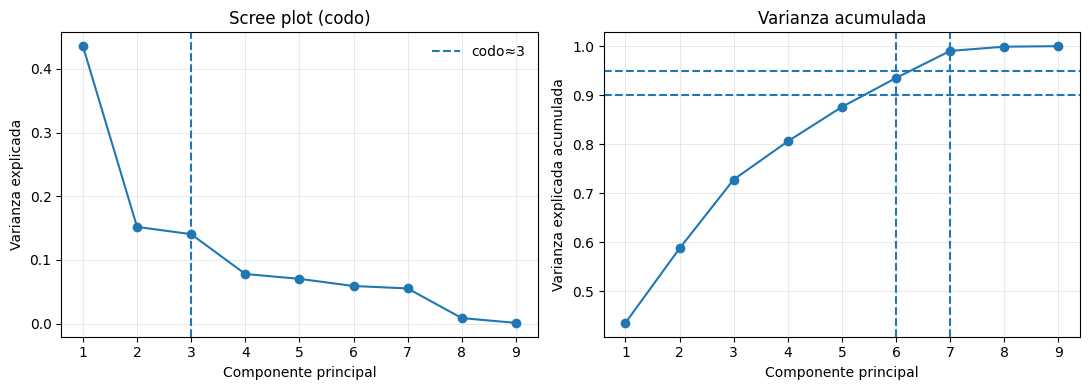

In [41]:
# --------- Gráficos ----------
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# (a) Scree / codo
axs[0].plot(ks, expl, marker="o")
axs[0].set_xlabel("Componente principal")
axs[0].set_ylabel("Varianza explicada")
axs[0].set_title("Scree plot (codo)")
axs[0].grid(True, linewidth=0.4, alpha=0.5)
axs[0].axvline(k_elbow, linestyle="--", label=f"codo≈{k_elbow}")
axs[0].legend(frameon=False)

# (b) Acumulada con líneas de referencia
axs[1].plot(ks, cum, marker="o")
axs[1].set_xlabel("Componente principal")
axs[1].set_ylabel("Varianza explicada acumulada")
axs[1].set_title("Varianza acumulada")
axs[1].grid(True, linewidth=0.4, alpha=0.5)
axs[1].axhline(0.90, linestyle="--"); axs[1].axvline(k90, linestyle="--")
axs[1].axhline(0.95, linestyle="--"); axs[1].axvline(k95, linestyle="--")

plt.tight_layout(); plt.show()

In [42]:
# Elige el número de componentes (puedes usar 0.95 para varianza acumulada)



###############################################
k = 7
###############################################



pca_pipe = Pipeline(steps=[
    ("pre", preprocessor_num),         # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()), # re-estandarización para usar correlaciones
    ("pca", PCA(n_components=k, svd_solver="full", random_state=0)),



])



# --- FIT en train ---
pca_pipe.fit(X_train_num)



# --- TRANSFORM en train y test ---
T_train = pca_pipe.transform(X_train_num)
T_test  = pca_pipe.transform(X_test_num)



# DataFrames de scores
pc_cols = [f"PC{i+1}" for i in range(T_train.shape[1])]
T_train_df = pd.DataFrame(T_train, columns=pc_cols, index=X_train_num.index)
T_test_df  = pd.DataFrame(T_test,  columns=pc_cols, index=X_test_num.index)



# Varianza explicada
pca_step = pca_pipe.named_steps["pca"]
expl = pca_step.explained_variance_ratio_
print("Varianza explicada:", np.round(expl, 6))
print("Acumulada:", np.round(np.cumsum(expl), 6))



# Guardar outputs (opcional)
T_train_df.to_csv("T_train_PCA.csv", index=False)
T_test_df.to_csv("T_test_PCA.csv", index=False)



print("Shapes -> T_train:", T_train_df.shape, "| T_test:", T_test_df.shape)
display(T_train_df.head())



Varianza explicada: [0.435737 0.151844 0.14042  0.077877 0.070218 0.059019 0.055197]
Acumulada: [0.435737 0.58758  0.728001 0.805878 0.876096 0.935115 0.990312]
Shapes -> T_train: (327, 7) | T_test: (110, 7)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
14,-1.477137,1.691553,0.957352,0.513384,-1.126519,0.212635,-0.455387
298,-2.171149,-1.557130,-0.087657,1.356527,0.310034,-0.319167,-0.227629
354,3.105425,1.459959,-0.324170,-1.422175,0.602097,0.053437,-0.302450
199,0.731003,0.777701,1.306709,0.492109,0.769146,1.659223,-0.659452
219,-2.454057,-1.050413,-0.752110,-0.758958,0.663332,1.089412,-0.062015


# FIGS

In [43]:
# Solo si k >= 2
import plotly.express as px

df_plot2 = T_train_df.iloc[:, :2].copy()
df_plot2["objetivo"] = y_train.loc[T_train_df.index].astype(str)
fig2 = px.scatter(df_plot2, x="PC1", y="PC2", color="objetivo",
                  opacity=0.85, title="PC1 vs PC2 por 'objetivo' (train)", height=550)
fig2.update_traces(marker=dict(size=6))
fig2.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig2.show()

In [44]:
#### Solo si k>=3
df_plot = T_train_df.iloc[:, :3].copy()          # PC1, PC2, PC3
# Alinea objetivo con los índices de T_train_df
df_plot["objetivo"] = y_train.loc[T_train_df.index].astype(str)

fig = px.scatter_3d(
    df_plot,
    x="PC1", y="PC2", z="PC3",
    color="objetivo",
    opacity=0.85,
    title="PC1–PC2–PC3 por ‘objetivo’ (train)",
    height=600
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"))
fig.show()


In [47]:
cols_num=['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6','PC7']

if len(cols_num) == 0:
    print("No hay columnas numéricas en final out. No se generan imágenes.")
else:
    # --------- Figura 1: HISTOGRAMAS (todos en subplots) ----------
    n = len(cols_num)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols_num):
        s = pd.to_numeric(T_train_df[col], errors="coerce").dropna()
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.hist(s, bins=30)
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")

    # Oculta subplots sobrantes
    for j in range(len(cols_num), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas de columnas numéricas", y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig("histogramas_numericas-scaled.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

    # --------- Figura 2: BOXPLOTS (todas en un eje) ----------
    series_pairs = []
    for c in cols_num:
        v = pd.to_numeric(T_train_df[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos numéricos válidos para boxplots. No se genera boxplot.")
        box_path = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6*len(labels)+4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots de columnas numéricas")
        plt.tight_layout()
        fig2.savefig("boxplots_numericas-scaled.png", dpi=150, bbox_inches="tight")
        plt.close(fig2)

In [18]:
# === Concatenar PCs (numéricas) con categóricas codificadas ===
# Asegura alineación por índice
df_train_cat_encode = df_train_cat_encode.reindex(T_train_df.index)
df_test_cat_encode  = df_test_cat_encode.reindex(T_test_df.index)

T_train_final = pd.concat([T_train_df, df_train_cat_encode], axis=1)
T_test_final  = pd.concat([T_test_df,  df_test_cat_encode], axis=1)

# Añadir columna objetivo (alineada por índice)
T_train_final_out = T_train_final.copy()
T_test_final_out  = T_test_final.copy()

T_train_final_out["objetivo"] = y_train.loc[T_train_final.index].astype(str)
T_test_final_out["objetivo"]  = y_test.loc[T_test_final.index].astype(str)


print("T_train_final:", T_train_final.shape)
print("T_test_final :", T_test_final.shape)

T_train_final.to_csv("T_train_final.csv", index=False)
T_test_final.to_csv("T_test_final.csv", index=False)
T_train_final_out.to_csv("T_train_final_objetivo.csv", index=False)
T_test_final_out.to_csv("T_test_final_objetivo.csv", index=False)
# X_train_final.head()

T_train_final: (327, 9)
T_test_final : (110, 9)


In [19]:
T_train_final_out

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,sex___1,sex___2,objetivo
14,-1.477137,1.691553,0.957352,0.513384,-1.126519,0.212635,-0.455387,1.0,0.0,118
298,-2.171149,-1.557130,-0.087657,1.356527,0.310034,-0.319167,-0.227629,0.0,1.0,129
354,3.105425,1.459959,-0.324170,-1.422175,0.602097,0.053437,-0.302450,0.0,1.0,272
199,0.731003,0.777701,1.306709,0.492109,0.769146,1.659223,-0.659452,1.0,0.0,90
219,-2.454057,-1.050413,-0.752110,-0.758958,0.663332,1.089412,-0.062015,1.0,0.0,185
...,...,...,...,...,...,...,...,...,...,...
323,3.646022,-0.512246,0.231740,1.304080,0.954428,1.398180,-0.503080,0.0,1.0,248
192,-0.769214,1.354167,0.803113,0.873207,-1.117007,0.165526,0.121606,0.0,1.0,91
117,3.659812,-0.415579,0.993515,0.754257,1.868428,0.400782,1.108959,1.0,0.0,281
47,-3.297338,-1.012676,-1.675564,0.312927,0.060905,1.200612,-0.165040,1.0,0.0,142


In [20]:
# === Guardar artefactos ===
import joblib
import json



# 1) Pipelines ya FIT: preprocessor_cat y pca_pipe
joblib.dump(preprocessor_cat, "preprocessor_cat.joblib")
joblib.dump(pca_pipe, "pca_pipe_num.joblib")   # (preprocessor_num + StdScaler + PCA)



# 2) Metadatos útiles para producción
meta = {
    "cols_num": cols_num,            # columnas numéricas originales
    "cols_cat": cols_cat,            # columnas categóricas originales
    "pc_cols": list(T_train_df.columns),            # nombres de PCs (PC1, PC2, …)
    "cat_out_cols": list(df_train_cat_encode.columns)  # columnas codificadas finales (OHE + Ordinal)
}
with open("pca_metadata.json", "w") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)



In [21]:
import os, zipfile, glob
# Guardamos los calculos y el proceso de los calculos
# Carpeta destino en tu PC
dst_dir = r"mi_pca"
os.makedirs(dst_dir, exist_ok=True)
zip_path = os.path.join(dst_dir, "pca_artifacts_bundle.zip")

# Archivos que quieres incluir (ajusta si te falta alguno)
candidates = [
    "T_test_PCA.csv",
    "T_test_final.csv",
    "T_test_final_objetivo.csv",
    "T_train_PCA.csv",
    "T_train_final.csv",
    "T_train_final_objetivo.csv",
    "boxplots_numericas.png",
    "histogramas_numericas.png",
    "pca_metadata.json",
    "pca_pipe_num.joblib",
    "preprocessor_cat.joblib",
]

present = [f for f in candidates if os.path.exists(f)]
# Si quieres incluir una carpeta (p. ej., 'sample_data'), descomenta:
# for root, _, files in os.walk("sample_data"):
#     for f in files:
#         present.append(os.path.join(root, f))

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for f in present:
        zf.write(f, arcname=os.path.basename(f))  # guarda sin subcarpetas

print("ZIP creado en:", zip_path)
print("Incluidos:", present)

ZIP creado en: mi_pca\pca_artifacts_bundle.zip
Incluidos: ['T_test_PCA.csv', 'T_test_final.csv', 'T_test_final_objetivo.csv', 'T_train_PCA.csv', 'T_train_final.csv', 'T_train_final_objetivo.csv', 'boxplots_numericas.png', 'histogramas_numericas.png', 'pca_metadata.json', 'pca_pipe_num.joblib', 'preprocessor_cat.joblib']


# Transform Final out